# Problem Session 7

In this problem session you will get some practice with:
* $\operatorname{AR}(p)$ models
* $\operatorname{MA}(q)$ models
* Time series cross validation

Question 1 and 2 use simulation to investigate $\operatorname{AR}(p)$ and $\operatorname{MA}(q)$ models respectively.

Question 3 applies a few different models to real data.  We use time series cross validation for model selection purposes.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1) Autoregressive Models

Recall that an autoregressive model of order $p$ is defined as follows:

The $\operatorname{AR}(p)$ model is

$$
y_t = \beta_1 y_{t-1} + \beta_2 y_{t-2} + \dots  + \beta_p y_{t - p} + \epsilon_t
$$

where $\epsilon_t \sim \operatorname{NID}(0,\sigma^2)$

$p$ is a hyperparameter and the $\beta_i$ and $\sigma^2$ are parameters which need to be fit. 

##### a)

In this first problem we will *simulate* some $\operatorname{AR}(2)$ data.  In particular we will simulate the following:

$$
\begin{cases}
y_0 &= \epsilon_0\\
y_1 &= \epsilon_1\\
y_t &= 0.5 y_{t-1} + 0.2 y_{t-2} + \epsilon_t
\end{cases}
$$

with $\epsilon_t \sim \mathcal{N}(0,1)$

Write python code to simulate one realization of this process!

Hint:  You will need to use `np.random.normal` and a "for loop".

In [3]:
sample_size = 1000
y = np.zeros(sample_size)
y[0] = 0
y[1] = 0
for i in range(2,sample_size):
    y[i] = 0.5*y[i-1] + 0.2*y[i-2] + np.random.normal()

# Note:  I simulated 10000 times and these asserts always passed.  
# Then I tried 100000 and one of them failed.
# So if you fail once you can be almost certain your code is wrong.
assert(type(y) == np.ndarray)
assert(len(y) == sample_size)
assert(np.abs(y.mean()) < 1)
assert(np.abs((y[1:]*y[:-1]).mean()) > 0.5)
assert(np.abs((y[1:]*y[:-1]).mean()) < 3)
assert(np.abs((y[50:]*y[:-50])).mean())


Plot the series.

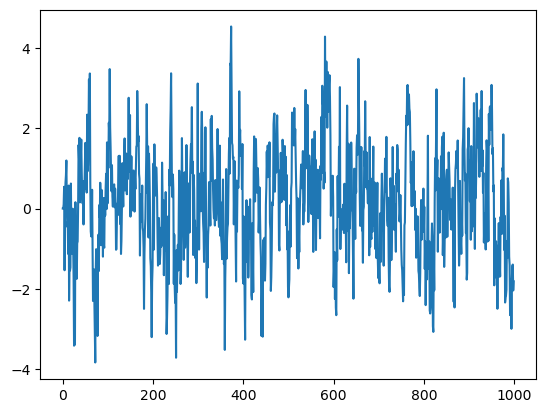

In [4]:
plt.plot(y)
plt.show()

##### b)

Plot the ACF and PACF plots of this time series.  Before making the plots, discuss what you *expect* to see with your group based on the theory covered in lecture.

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

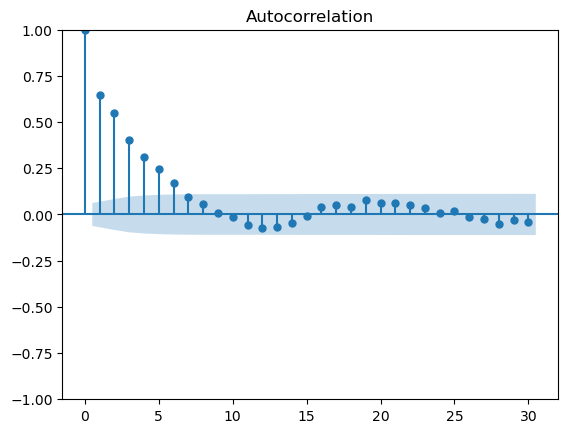

In [6]:
plot_acf(y)
plt.show()

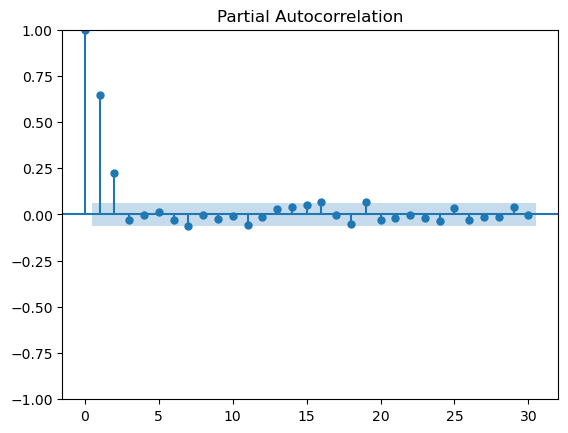

In [7]:
plot_pacf(y)
plt.show()

##### c)  

We will now attempt to estimate the parameters by simply regressing $y_t$ on $y_{t-1}$ and $y_{t-2}$.

Write a function called `X_y_for_lags` which works as follows:

$$
\operatorname{X\_y\_for\_lags}([1,2,3,4,5,6],2) =  \left(
\begin{bmatrix} 
1 & 2\\
2 & 3\\
3 & 4\\
4 & 5
\end{bmatrix},
\begin{bmatrix} 3, 4, 5, 6\end{bmatrix} 
\right)
$$

In [8]:
def X_y_for_lags(ts, num_lags):
    '''
    Inputs
        ts: A numpy array of size (n,) representing a time series
        num_lags: The number of lags to include in the resulting design matrix

    Outputs
        X: A numpy array of size (n - num_lags, num_lags). 
            The first column is lag 1, second column is lag 2, etc 
        y: The time series starting at entry num_lags
    '''
    ts = ts.astype(float)
    n = len(ts)
    X = np.zeros(shape = (n - num_lags, num_lags))
    for i in range(num_lags):
        X[:, i] = ts[i:i + n - num_lags]
    y =  ts[num_lags:]
    return (X,y)

assert np.array_equal(X_y_for_lags(
    np.array([1,2,3,4,5,6]),2)[0], 
    np.array([[1., 2.],
        [2., 3.],
        [3., 4.],
        [4., 5.]])
        )

assert np.array_equal(X_y_for_lags(
    np.array([1,2,3,4,5,6]),2)[1], 
    np.array([3., 4., 5., 6.])
        )

Now fit a linear regression model to estimate the parameters.  How close do you get to recovering the parameters (which were $0.5$ and $0.2$)?

In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
ar_model = LinearRegression()
ar_model.fit(*X_y_for_lags(y, 2))
ar_model.coef_

array([0.22800969, 0.49902856])

Instead of doing this manually, we can instead use a python package which can handle $\operatorname{AR}(p)$ model estimation.  One such package is `pmdarima`, which wraps statsmodels ARIMA packages.

ARIMA stands for AutoRegressive Moving Averages.  We can use ARIMA with just the AR part for our purposes.

In [11]:
import pmdarima as pm

`pm.ARIMA` has a kwarg called `order`.  If we set `order = (p,d,q)` then our ARIMA model has 

* An $\operatorname{AR}(p)$ component 
* Has been differenced $d$ times before estimation (and so needs to be "Integrated" $d$ times)
* Has an $\operatorname{MA}(q)$ component.

So we can fit an $\operatorname{AR}(2)$ model using `order = (2,0,0)`

In [12]:
arima = pm.ARIMA(order=(2, 0, 0))
arima.fit(y)

ARIMA(order=(2, 0, 0))

In [13]:
arima.params()[[1,2]]

array([0.49854045, 0.22756091])

This should be close to what we got using linear regression.

In [14]:
# It might be interesting to "run all cells above" 
# a few times to see the variability in parameter estimates.
# Note that this is 1000 time points from a series we *know* follows an  
# AR(2) process.  You can imagine how hard it is to estimate these things 
# on real data.

### 2) Moving Average models

The $\operatorname{MA}(q)$ model is

$$
y_t = \epsilon_t + \alpha_1 \epsilon_{t-1} + \alpha_2 \epsilon_{t-2} + \dots + \alpha_q \epsilon_{t-q}
$$

where $\epsilon_t \sim \operatorname{NID}(0,\sigma^2)$

$q$ is a hyperparameter and the $\alpha_i$ and $\sigma^2$ are parameters which need to be fit. 

##### a)

We will simulate some $\operatorname{MA}(2)$ data.  In particular we will simulate the following:

$$
y_t = \epsilon_t + 0.5\epsilon_{t-1} + 0.2\epsilon_{t-2}
$$

with $\epsilon_t \sim \mathcal{N}(0,1)$

Write python code to simulate one realization of this process!

Hint:  You will need to use `np.random.normal` but you will not need a "for loop"!

In [15]:
sample_size = 1000
es = np.random.normal(size = sample_size + 2)
ts = es[2:] + 0.5*es[1:-1] + 0.3*es[:-2]

# Note:  These asserts all passed 100000 times.
assert(len(ts) == sample_size)
assert((ts[1:]*ts[:-1]).mean() > 0.1)
assert(np.abs((ts[3:]*ts[:-3]).mean()) < 0.3)

Plot the time series:

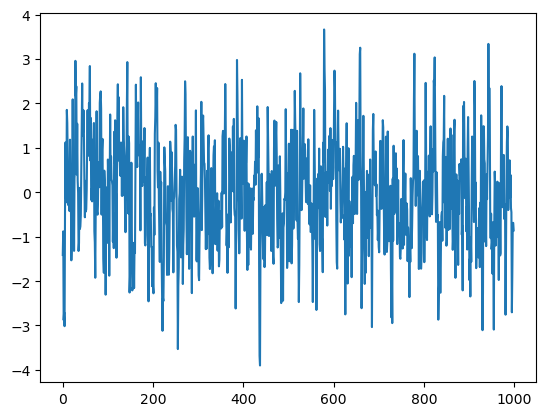

In [16]:
plt.plot(ts)
plt.show()

##### b)

Plot the ACF and PACF plots of this time series.  Before making the plots, discuss what you *expect* to see with your group based on the theory covered in lecture.

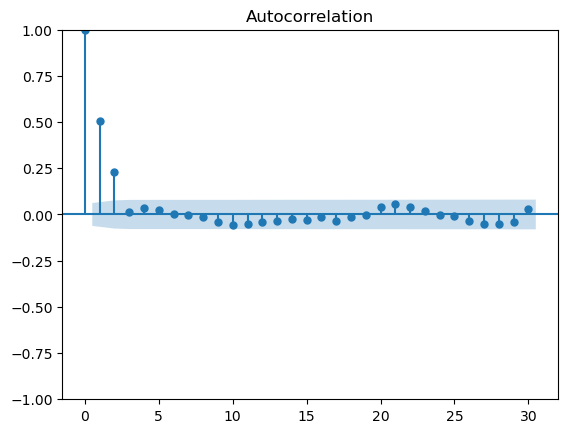

In [17]:
plot_acf(ts)
plt.show()

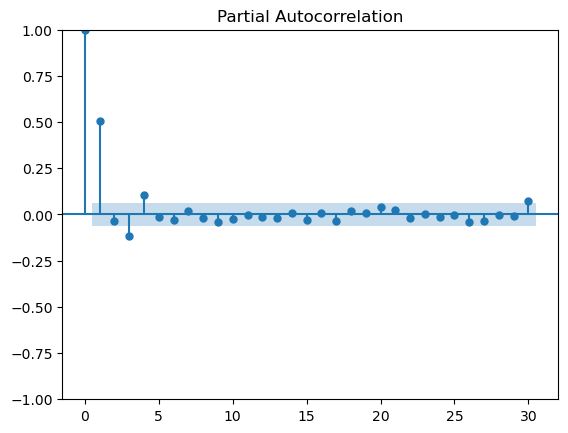

In [18]:
plot_pacf(ts)
plt.show()

##### c)

Parameter estimation for $\operatorname{MA}(q)$ models is tougher than for $\operatorname{AR}(p)$ models so we will not attempt this "by hand".

Fit an $\operatorname{MA}(2)$ model to the data using `pm.ARIMA`.

In [19]:
arima = pm.ARIMA(order=(0, 0, 2), with_intercept = False)
arima.fit(ts)

ARIMA(order=(0, 0, 2), with_intercept=False)

In [20]:
arima.params()

array([0.54276583, 0.3168988 , 1.03626349])

In [21]:
# Again it might be nice to "run all cells above" a few times.

### 3) Lynx data

The Lynx dataset records the number of lynx skins collected by the Hudson’s Bay Company from 1821 to 1934.

In [22]:
from pmdarima.datasets import load_lynx
y = load_lynx(True)

In [23]:
# Use all but the last 20 years as our training set.
y_train = y.iloc[:-20]

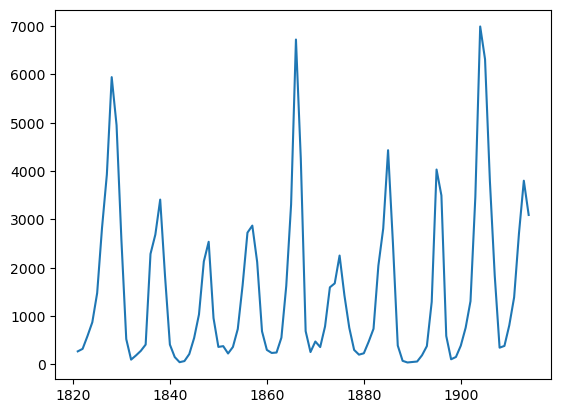

In [24]:
plt.plot(y_train.index, y_train.values)
plt.show()

##### a)  

Plot the ACF and PACF plots of the training data.  What models do they suggest we might try?  Discuss with your group.

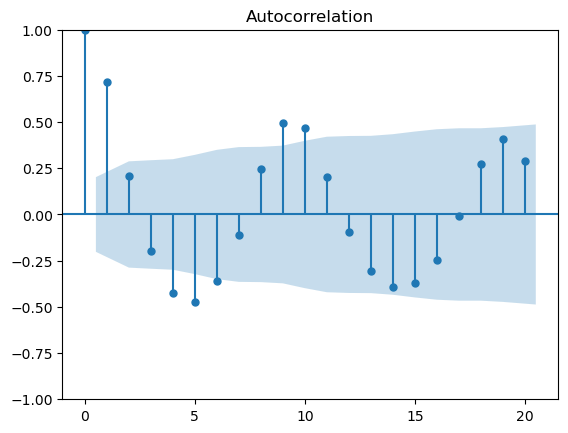

In [25]:
plot_acf(y_train)
plt.show()

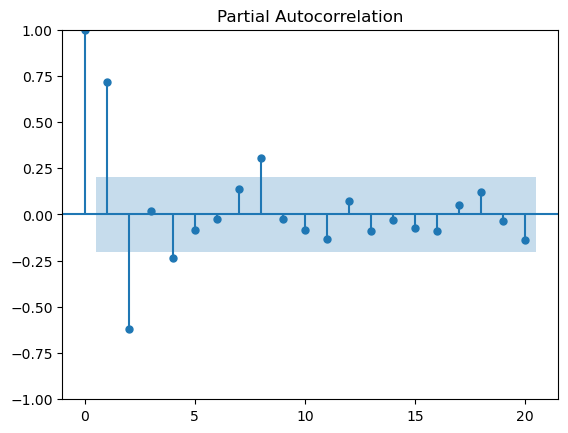

In [26]:
plot_pacf(y_train)
plt.show()

Interestingly $\operatorname{PACF}(1)$ is positive and $\operatorname{PACF}(2)$ is negative. Think about what that means in terms of the regression coefficients!  This is what is driving the "boom/bust" cycle we observe.

##### b)

`pm.auto_arima` will search through different values of $(p,d,q)$ and attempt to find one that minimizes the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion).  This information theoretic approach to model selection is an alternative to cross validation (it is an approximation of leave-out-one cross validation error).

In [27]:
from pmdarima import auto_arima

In [28]:
auto_arima(y_train, trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1551.254, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1662.120, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1595.873, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1587.456, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1719.871, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1561.525, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1553.513, Time=0.02 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1554.704, Time=0.04 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1563.500, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1564.703, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1555.498, Time=0.02 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1573.443, Time=0.02 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] interc

ARIMA(order=(2, 0, 2), scoring_args={}, suppress_warnings=True)

`auto_arima` has selected a model with both an $\operatorname{AR}(2)$ component and an $\operatorname{MA}(2)$ component.  In other words, the model is:

$$
y_{t} = \beta_1 y_{t-1} + \beta_2 y_{t-2} +  \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2}
$$

where $\epsilon_t$ are Gaussian white noise.

##### c)

In this last section we will compare the following 4 models using time series cross validation:

* Model 0: A baseline "Naive" forecast
* Model 1: An $\operatorname{AR}(2)$ model.
* Model 2: A model which regresses $y_t$ on $y_{t-1}, y_{t-2}$, and $y_{t-8}$.  This model is suggested by the significant value of $\operatorname{PACF}(8)$.
* Model 3: Whatever model is selected by `auto_arima` in each fold.  Note that we are allowing the order to change as we see new data!

Here is our cross validation scheme:

* We are focused on a forecasting horizon of one year.
* We will reserve the last 10 years as a testing set, so we will not look at them during cross validation.
* In each fold:
    * Fold 1: Train on [:-10] and then predict [-10].
    * Fold 2: Train on [:-9] and predict [-9].
    * $\vdots$
    * Fold 10: Train on [:-1] and predict on [-1]
* Store these predictions and compare them to y_train[-10:].


In [29]:
model1 = LinearRegression()
model2 = LinearRegression()

model0_preds = []
model1_preds = []
model2_preds = []
model3_preds = []

# Model 2 is "custom" so we will fit it using linear regression.
design_matrix, targets = X_y_for_lags(y_train, 8)

for i in range(10, 0, -1):
    X_tt, y_tt = design_matrix[:-i], targets.iloc[:-i]

    # The holdout data should have a single row!
    X_ho, y_ho = design_matrix[[-i]], targets.iloc[-i]

    # X_tt_1 is used for model 1 and should only use lags 1 and 2
    X_tt_1 = X_tt[:,[0,1]]

    # X_tt_2 is used for model 2 an should only use lags 1, 2 and 8
    X_tt_2 = X_tt[:,[0,1,7]]

    X_ho_1 = X_ho[:,[0,1]]
    X_ho_2 = X_ho[:,[0,1,7]]

    # Fit the models
    model1.fit(X_tt_1, y_tt)
    model2.fit(X_tt_2, y_tt)
    model3 = auto_arima(y_tt)

    # Model 0 is the naive forecast
    model0_preds.append(y_tt.iloc[-1])
    model1_preds.append(model1.predict(X_ho_1)[0])
    model2_preds.append(model2.predict(X_ho_2)[0])
    model3_preds.append(model3.predict(1))

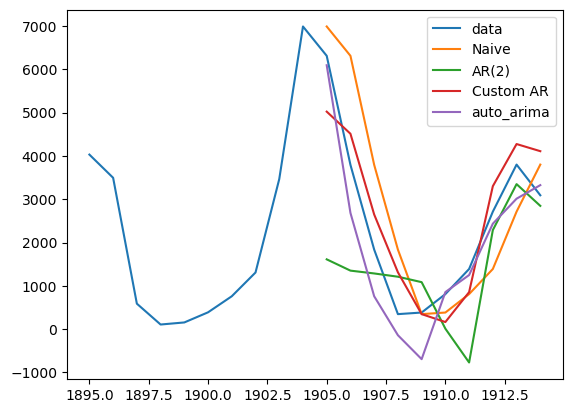

In [30]:
plt.plot(y_train.index[-20:], y_train.iloc[-20:], label = 'data')
plt.plot(y_train.index[-10:], model0_preds, label = 'Naive')
plt.plot(y_train.index[-10:], model1_preds, label = 'AR(2)')
plt.plot(y_train.index[-10:], model2_preds, label = 'Custom AR')
plt.plot(y_train.index[-10:], model3_preds, label = 'auto_arima')
plt.legend()
plt.show()

None of these look especially great, but let's see if we at least found a model which outperforms our baseline.

In [31]:
from sklearn.metrics import mean_squared_error as mse

In [32]:
mse(y_train[-10:],model0_preds)

1682101.0

In [33]:
mse(y_train[-10:],model1_preds)

3537507.7476097345

In [34]:
mse(y_train[-10:],model2_preds)

608568.853737729

In [35]:
mse(y_train[-10:],model3_preds)

461495.78421298816

##### d)

Sadly, neither model 1 nor 2 outperformed the naive baseline model but model 3 (the `auto_arima`) model, did!

See how model 3 does on the testing set. 

In [36]:
model3_preds = []

for i in range(10, 0, -1):
    y_tt = y[:-i]

    model3 = auto_arima(y_tt)

    model3_preds.append(model3.predict(1))

mse(y.iloc[-10:],model3_preds)

218414.4266720944

We actually achieve a lower MSE on the test set than we did in cross validation!

Let's take a look at how we did visually:

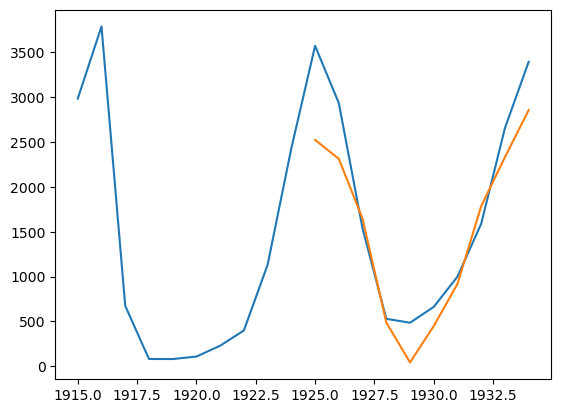

In [37]:
plt.plot(y.index[-20:], y.iloc[-20:], label = 'data')
plt.plot(y.index[-10:], model3_preds, label = 'final model')
plt.show()